# Procedure for statistical analysis of trajectories

1. use the package `MTS` from R to compute the p-values across the `x` and `y` aggregated trajectories. Use a p-value of 1 for trajectories for which there are no observed correlations. This is using the Ljung-Box statistic.
2. Aggregate the p-values using Fisher's method:
`pchisq(-2*sum(log(p-balues)), df, lower.tail=FALSE)` where `df=2*length(p-values)`

In [40]:
library('ggplot2')
library('dplyr')
library('tidyr')
library('MTS')
library('cowplot')
library('psychometric')

Loading required package: multilevel
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select


Attaching package: ‘psychometric’

The following object is masked from ‘package:psych’:

    alpha

The following object is masked from ‘package:ggplot2’:

    alpha



In [9]:
trajectories <- read.csv("../data/trajectory_df.csv", header = TRUE)

In [10]:

trajectories$pair_id <- as.factor(trajectories$pair_id)
trajectories$channel <- as.factor(trajectories$channel)

In [11]:
positives = c(    
    "with glucose 4 but have flow",
    "with glucose with 20X objective",
    "with glucose 5",
    "with glucose 2",
    "with glucose 3"
     )

negatives = c(
 #   "with glucose 4 but have flow",
    "no glucose",
    "l-glu")

In [12]:
trajectories <- trajectories %>% 
        mutate(positive = ifelse(filename %in% positives, 1, 0))

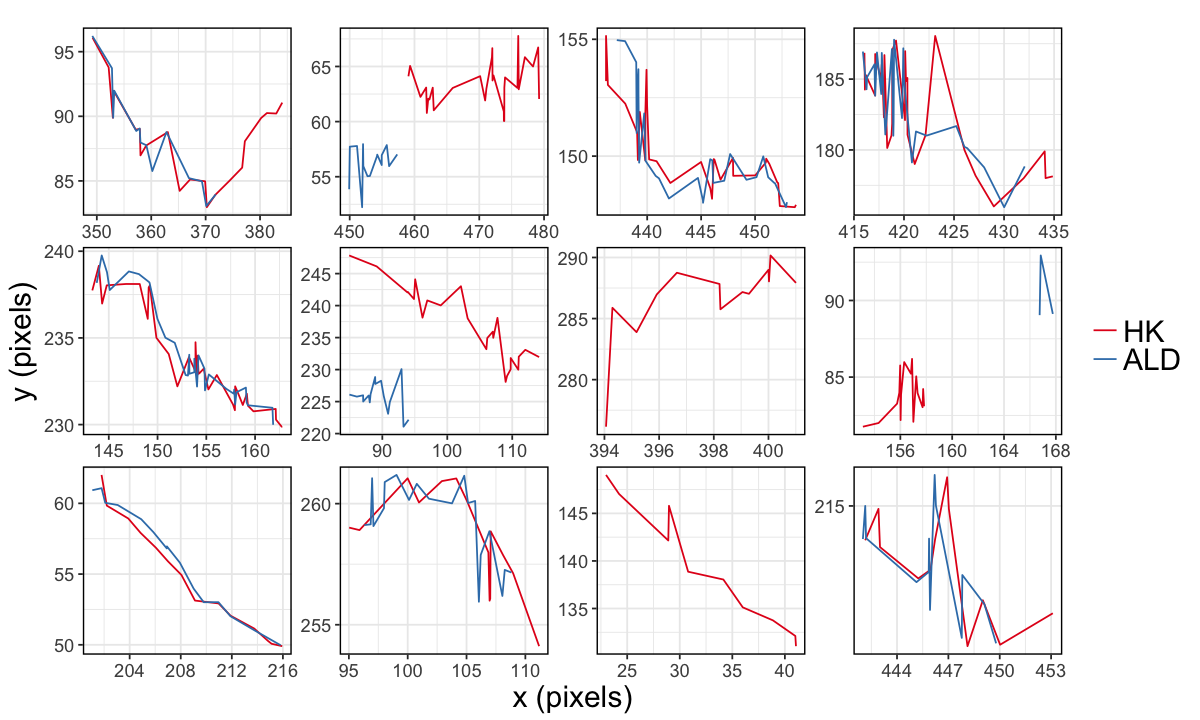

In [13]:
options(repr.plot.width = 10, repr.plot.height = 6)
p <- ggplot(data = filter(trajectories, filename == 'with glucose 2'), 
                aes(x = x, y = y, color = factor(channel))) + geom_line() + 
                facet_wrap(~pair_id, scale = "free") +
                theme_bw() +
        xlab("x (pixels)") +
        ylab("y (pixels)") +
                 theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=11),
        axis.text.x = element_text(size=11),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        legend.title=element_blank(),
        legend.text=element_text(size=18),
         strip.text = element_text(size = 0, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
                      panel.spacing.y = unit(-.35555, "lines")) +
scale_y_continuous(breaks = seq(0, 800, by=5)) +
scale_color_brewer(palette = 'Set1',labels = c("HK","ALD"))
            
p

In [8]:
ggsave("../img/aggregate_trajectory.png", width =10, height =6)

## Helper Function definitions

In [14]:
# this returns the p values given a data frame with several trajectories
trajectory_p_vals <- function(df, func, default) {
    p_vals <- 0
    i <- 1
     for (pair in unique(df$pair_id)) {
        # print(pair)
        this_df <- df %>% filter(pair_id == pair)
         
         p_vals[i] <- single_trajectory_p_val_x(this_df, func, default)
         i <- i+1
         p_vals[i] <- single_trajectory_p_val_y(this_df, func, default)
         i <- i+1
     }

    p_vals
}

my_ccm_func <- function(df) {
    res <- ccm(df, output = FALSE, lags=1)
    res$pvalue[1]
}

my_cor_func <- function(df) {
    cor(df)[2,1]
}

single_trajectory_p_val_x<- function(df, func, default) {
    ispresent <- df %>% select(x, channel, frame)

    if(length(unique(ispresent$channel))> 1) {
        to_run_df <- ispresent %>% 
         spread(channel, x) %>%
         select(2:3) %>%
         na.omit()
        
        if(nrow(to_run_df) >5) {
             res <- to_run_df %>% func()
            p_val <- res
        } else {
            p_val <- default
        }
    } else {
        p_val <- default
    }
   p_val 
}
    
single_trajectory_p_val_y<- function(df, func, default) {
    ispresent <- df %>% select(y, channel, frame)

    if(length(unique(ispresent$channel))> 1) {
        to_run_df <- ispresent %>% 
         spread(channel, y) %>%
         select(2:3) %>%
         na.omit() 
        
        if(nrow(to_run_df) >5) {
             res <- to_run_df %>% func()
            p_val <- res
        } else {
            p_val <- default
        }
    } else {
        p_val <- default
    }
   p_val 
}
# this take a vector of p values and aggregates it using Fisher's method
aggregate_pvals <- function(p_vals) {
    p_vals <- p_vals[p_vals>0]
    n_df <- 2* length(p_vals)
    pchisq(-2*sum(log(p_vals)), n_df, lower.tail=FALSE) 
}

### Running the analysis
First we run  the analysis for all p-values, creating two vectors of p-values

In [30]:
positive_ps <- vector()
negative_ps <- vector()

for (fn in unique(trajectories$filename)) {
    df = filter(trajectories, filename == fn)
    if(fn %in% positives) {
        print(fn)
        positive_ps = c(positive_ps, trajectory_p_vals(df, my_ccm_func, 1))
    } else if (fn %in% negatives) {
        print(fn)
        negative_ps = c(negative_ps, trajectory_p_vals(df, my_ccm_func, 1))
    }
}


[1] "with glucose 4 but have flow"
[1] "with glucose with 20X objective"
[1] "with glucose 5"
[1] "with glucose 2"
[1] "with glucose 3"
[1] "no glucose"
[1] "l-glu"


In [31]:
# this shows the aggregated p value for the positive frames
aggregate_pvals(positive_ps)

[1] 1.329668e-130

[1] 0.1204858 0.5513649 1.0000000 1.0000000

In [34]:
# this shows the aggregated p value for the negative frames
aggregate_pvals(negative_ps)

[1] 0.7115371

We split the negative frames by experimental condition

In [38]:
df = filter(trajectories, filename == 'no glucose')

In [41]:
aggregate_pvals(trajectory_p_vals(df, my_ccm_func, 1))

[1] 0.2465665

We can repeat the analysis for the correlation - but this is not used in the paper. Confusing!

In [21]:
positive_cors <- vector()
negative_cors <- vector()

for (fn in unique(trajectories$filename)) {
    df = filter(trajectories, filename == fn)
    if(fn %in% positives) {
        print(fn)
        positive_cors = c(positive_cors,
                          trajectory_p_vals(df, my_cor_func, 0))
    } else if (fn %in% negatives) {
        print(fn)
        negative_cors = c(negative_cors,
                          trajectory_p_vals(df, my_cor_func, 0))
    }
}

[1] "with glucose 4 but have flow"
[1] "with glucose with 20X objective"
[1] "with glucose 5"
[1] "with glucose 2"
[1] "with glucose 3"
[1] "no glucose"
[1] "l-glu"


### Counting for the SI table

In [67]:
length(positive_cors)

[1] 106

In [36]:
x_corrs = positive_cors[seq(1,106,2)]

In [37]:
y_corrs = positive_cors[seq(2,106,2)]

In [41]:
corrs <- pmin(x_corrs, y_corrs)

In [66]:
N = length(corrs)
print(paste("total number of hexokinase trajectories", N))
print(paste("number of correlations above 95%", length(corrs[corrs>.95])))

[1] "total number of hexokinase trajectories 53"
[1] "number of correlations above 95% 30"


## Figure for main manuscript

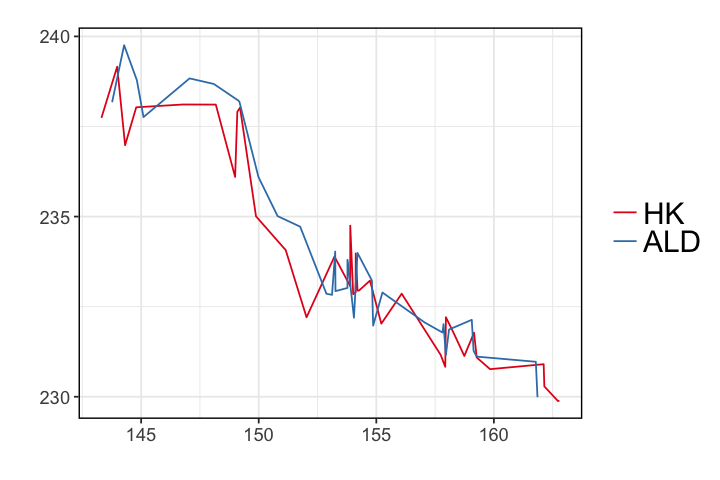

In [127]:
options(repr.plot.width = 6, repr.plot.height = 4)
f1 <- ggplot(data = filter(trajectories, filename == 'with glucose 2', pair_id==4), 
                aes(x = x, y = y, color = factor(channel))) + geom_line() + 
                facet_wrap(~pair_id, scale = "free") +
                theme_bw() +
        xlab("") +
        ylab("") +
                 theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=11),
        axis.text.x = element_text(size=11),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        legend.title=element_blank(),
        legend.text=element_text(size=18),
         strip.text = element_text(size = 0, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
                      panel.spacing.y = unit(-.35555, "lines")) +
scale_y_continuous(breaks = seq(0, 800, by=5)) +
scale_color_brewer(palette = 'Set1',labels = c("HK","ALD"))
            
f1

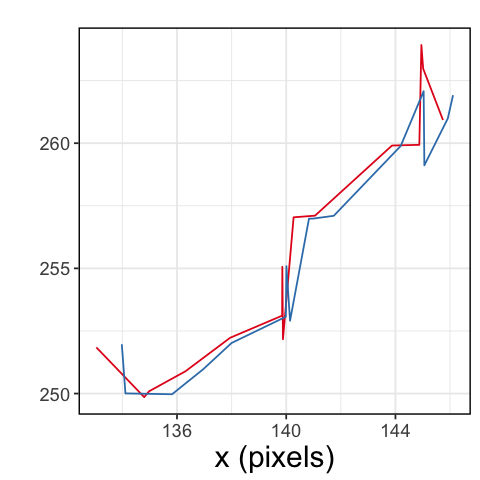

In [125]:
options(repr.plot.width = 4, repr.plot.height = 4)
f2 <- ggplot(data = filter(trajectories, filename == 'with glucose 4 but have flow', pair_id == 3), 
                aes(x = x, y = y, color = factor(channel))) + geom_line() + 
                facet_wrap(~pair_id, scale = "free") +
                theme_bw() +
        xlab("x (pixels)") +
        ylab("") +
                 theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=11),
        axis.text.x = element_text(size=11),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        legend.title=element_blank(),
        legend.text=element_text(size=18),
         strip.text = element_text(size = 0, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
                      panel.spacing.y = unit(-.35555, "lines")) +
scale_y_continuous(breaks = seq(0, 800, by=5)) +
scale_color_brewer(palette = 'Set1',labels = c("HK","ALD"), guide='none')
            
f2

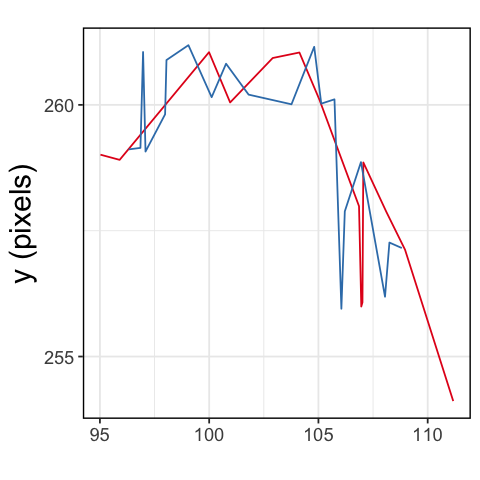

In [123]:
options(repr.plot.width = 4, repr.plot.height = 4)
f3 <- ggplot(data = filter(trajectories, filename == 'with glucose 2', pair_id == 9), 
                aes(x = x, y = y, color = factor(channel))) + geom_line() + 
                facet_wrap(~pair_id, scale = "free") +
                theme_bw() +
        xlab("") +
        ylab("y (pixels)") +
                 theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=11),
        axis.text.x = element_text(size=11),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        legend.title=element_blank(),
        legend.text=element_text(size=18),
         strip.text = element_text(size = 0, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
                      panel.spacing.y = unit(-.35555, "lines")) +
scale_y_continuous(breaks = seq(0, 800, by=5)) +
scale_color_brewer(palette = 'Set1',labels = c("HK","ALD"), guide='none')
            
f3

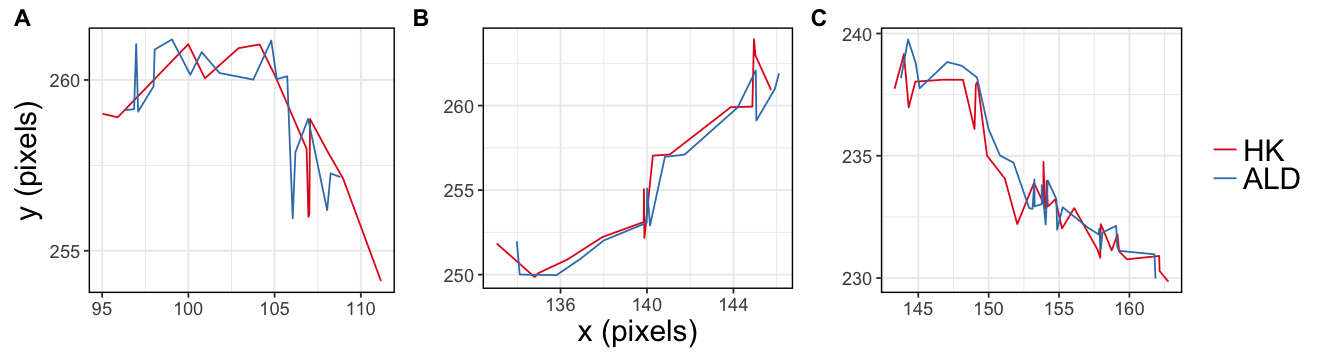

In [130]:
options(repr.plot.width = 11, repr.plot.height = 3)
final = plot_grid(f3, f2, f1, labels = c("A", "B","C"), ncol=3, rel_widths=c(1,1,1.3))
final

In [131]:
ggsave("../img/example_for_main.png", width =11, height =3)